## Dogs v Cats

In [48]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [49]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [50]:
def hotspot(x):
    x = x[None,0]
    vx = Variable(x.cuda(), requires_grad=True)
    sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]
    py = m(Variable(x.cuda()))
    for o in sfs: o.remove()
    py = np.exp(to_np(py)[0])
    feat = np.maximum(0,to_np(sfs[3].features[0]))
    f2=np.dot(np.rollaxis(feat,0,3), py)
    f2-=f2.min()
    f2/=f2.max()
    dx = data.val_ds.denorm(x)[0]
    plt.imshow(dx)
    plt.imshow(resize(f2, dx.shape), alpha=0.5, cmap='hot');

In [51]:
#PATH = "/home/ubuntu/data/dogscats/"
PATH = "/home/ubuntu/data/flintstones/"
sz = 224
arch = resnet34
bs = 64

In [52]:
m = arch(True)

In [53]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [54]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [55]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
hotspot_data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=1)

In [56]:
iterator = iter(hotspot_data.val_dl)
x,y = next(iterator)

In [57]:
learn = ConvLearner.from_model_data(m, data)

In [58]:
learn.unfreeze

<bound method ConvLearner.unfreeze of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      3.908462   2.508657   0.773438  



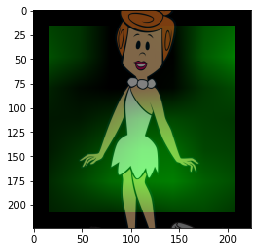

In [59]:
learn.fit(0.01, 1)
hotspot(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.703871   1.241103   0.953125  



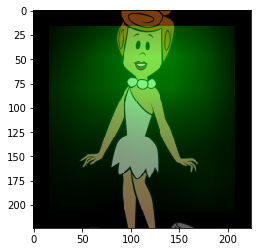

In [60]:
learn.fit(0.01, 1)
hotspot(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.262396   0.233327   0.945312  



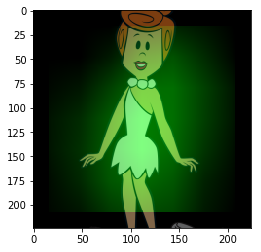

In [61]:
learn.fit(0.01, 1)
hotspot(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.106465   0.101343   0.976562  



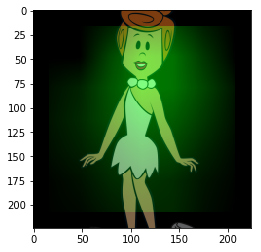

In [62]:
learn.fit(0.01, 1)
hotspot(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.048091   0.251107   0.960938  



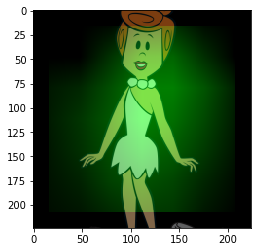

In [63]:
learn.fit(0.01, 1)
hotspot(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.036756   0.35641    0.953125  



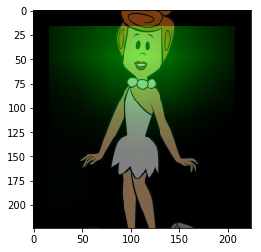

In [64]:
learn.fit(0.01, 1)
hotspot(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.031411   0.110944   0.960938  



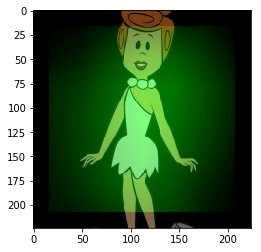

In [65]:
learn.fit(0.01, 1)
hotspot(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch      trn_loss   val_loss   accuracy   
    0      0.058084   0.141611   0.945312  



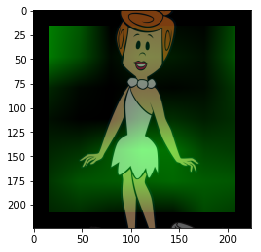

In [66]:
learn.fit(0.01, 1)
hotspot(x)